In [85]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
from torchvision import transforms
import h5py
import rbm
import rbmg
import rbmg2
from plyer import notification
from scipy.optimize import linear_sum_assignment

In [86]:
time22 = [10,48,136,160,258,272,384,516,544,768,1028,1056,1280,2050,2064,2176,4096,4112,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152]

In [87]:
tlist = sorted(time22, reverse=True)

In [88]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def Hsampling(W,b_h,V):
        
        h_mean = (W.mm(V).t() + b_h).t()
        mh = h_mean #sin sigmoide?
        h = torch.normal(mean=h_mean, std=torch.ones_like(h_mean))

        return h,mh

def Sampling(X,W,b_h,b_v,it): 
        L = X.shape[0]
        N = X.shape[1]
        
        if it==0:
            it = 10

        v = X

        h,mh = Hsampling(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)

        
        for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
            
        q = []
        q2 = []
        for i in range (N):
            for j in range (i+1,N):
                
                f = torch.mean((2*v[:,i]-1)*(2*v[:,j]-1))
                q.append(f) 
                q2.append(torch.pow(f, 2))
        
            
        chi = (1000*(torch.mean(m2)-torch.mean(m)**2).item())
        chi2 = ((np.mean(q2)-np.mean(q)**2)/1000).item()
        
        chi_std = torch.std(torch.tensor(q)).item()
        chi2_std = torch.std(torch.tensor(q2)).item()  
            
        return np.array(m),np.array(chi),np.array(chi2),v,chi_std,chi2_std #estoy guardando todas las m y la última v

In [91]:

allt = []
allm = []
allchi = []
allchichi = []
alls = []
chi_std = []
chi2_std = []

filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.zeros(1000,50)

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X,a,b = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)
    allchichi.append(chi2)
    chi_std.append(a)
    chi2_std.append(b)
    
alls = torch.cat(tuple(alls),dim=1)

In [92]:
allt2 = []
allm2 = []
allchi2 = []
allchichi2 = []
alls2 = []
chi_std2 = []
chi2_std2 = []

filename ='files/RDMG_CWM_1p5L100_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')
tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]

X = torch.zeros(100,500)

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls2.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X,a,b = Sampling(X,W,b_h,b_v,it)
    
    allt2.append(t)
    allm2.append(m)
    allchi2.append(chi)
    allchichi2.append(chi2)
    chi_std2.append(a)
    chi2_std2.append(b)
    
alls2 = torch.cat(tuple(alls2),dim=1)

Text(0, 0.5, '$\\chi$')

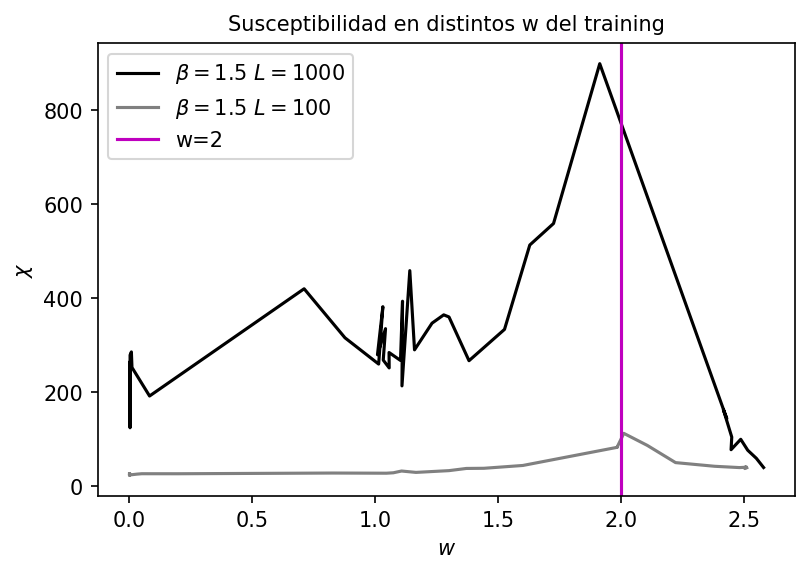

In [125]:
plt.figure(dpi = 150)
y = np.array(allchi)
plt.plot(alls.squeeze(0), y*1000, color = 'k',label = r'$\beta = 1.5 \ L = 1000$')

y2 = np.array(allchi2)

plt.plot(alls2.squeeze(0), y2*10, color = 'grey',label = r'$\beta = 1.5 \ L = 100$',)

plt.title('Susceptibilidad en distintos w del training',fontsize = 10)
plt.xlabel('$w$')
plt.axvline( x = 2, color = 'm',label = 'w=2')
plt.legend()
plt.ylabel(r'$\chi$')

Text(0, 0.5, '$\\chi_q$')

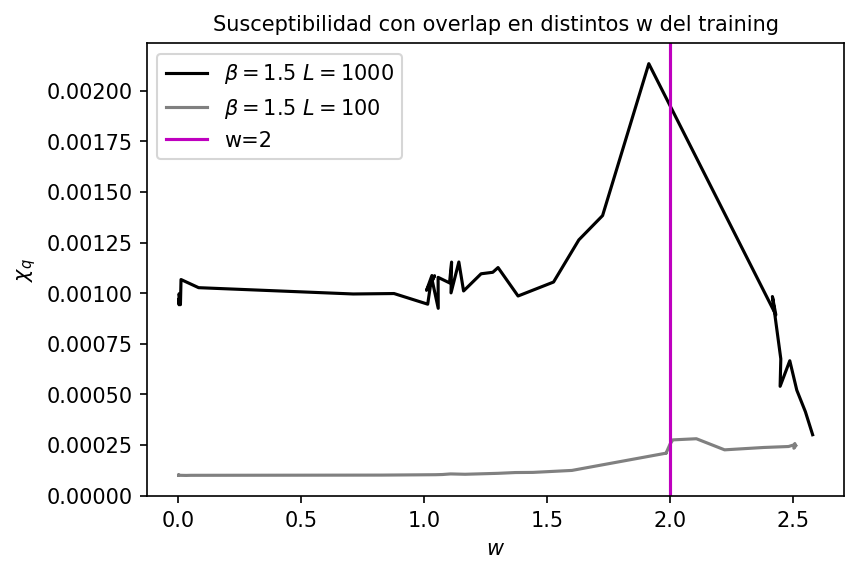

In [128]:
plt.figure(dpi = 150)
y = np.array(allchichi)
plt.plot(alls.squeeze(0), y*1000, color = 'k',label = r'$\beta = 1.5 \ L = 1000$')

y2 = np.array(allchichi2)

plt.plot(alls2.squeeze(0), y2*10, color = 'grey',label = r'$\beta = 1.5 \ L = 100$',)

plt.title('Susceptibilidad con overlap en distintos w del training',fontsize = 10)
plt.xlabel('$w$')
plt.axvline( x = 2, color = 'm',label = 'w=2')
plt.legend()
plt.ylabel(r'$\chi_q$')

Text(0, 0.5, '$\\chi$')

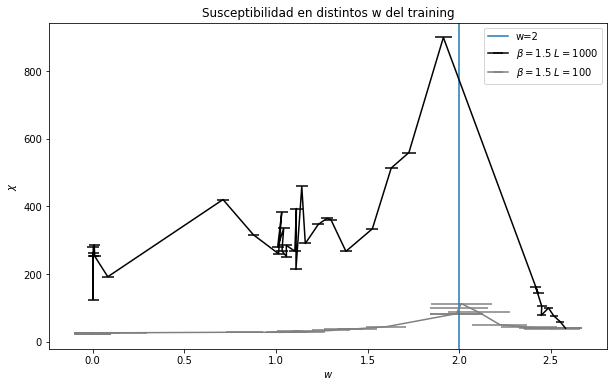

In [117]:
fig, ax = plt.subplots(figsize=(10, 6))

y = np.array(allchi)

ax.errorbar(alls.squeeze(0), y*1000, xerr=chi_std, color = 'k',label = r'$\beta = 1.5 \ L = 1000$')

y2 = np.array(allchi2)

ax.errorbar(alls2.squeeze(0), y2*10, xerr=chi_std2, color = 'grey',label = r'$\beta = 1.5 \ L = 100$',)

plt.title('Susceptibilidad en distintos w del training')
plt.xlabel('$w$')
plt.axvline( x = 2, label = 'w=2)
plt.legend()
plt.ylabel(r'$\chi$')

Text(0, 0.5, '$\\chi_q$')

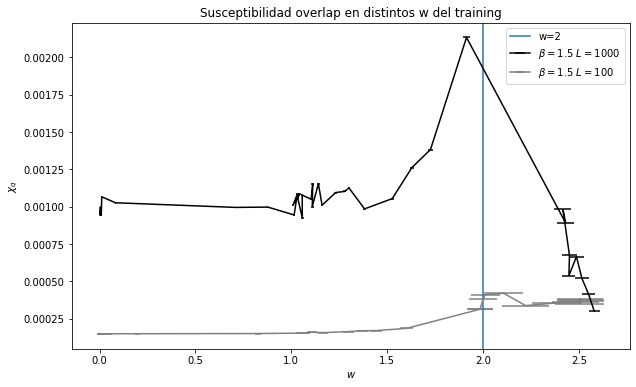

In [119]:
fig, ax = plt.subplots(figsize=(10, 6))

y = np.array(allchichi)

ax.errorbar(alls.squeeze(0), y*1000, xerr=chi2_std, color = 'k',label = r'$\beta = 1.5 \ L = 1000$')

y2 = np.array(allchichi2)

ax.errorbar(alls2.squeeze(0), y2*15, xerr=chi2_std2, color = 'grey',label = r'$\beta = 1.5 \ L = 100$',)

plt.title('Susceptibilidad overlap en distintos w del training')
plt.xlabel('$w$')
plt.axvline( x = 2, label = 'w=2')
plt.legend()
plt.ylabel(r'$\chi_q$')

In [107]:
ax.errorbar(alls.squeeze(0), y*1000, xerr=chi_std, fmt='o', capsize=5, label='chi')

<ErrorbarContainer object of 3 artists>

In [97]:
len(allchi)

37

In [ ]:
y = np.array(allchi)
plt.plot(alls.squeeze(0), y*1000,'k',label = r'$\beta = 1.5 \ L = 1000$')
ax.errorbar(puntos, chi_values, yerr=chi_std_values, fmt='o', capsize=5, label='chi')

y5= np.array(allchi2)
plt.plot(alls5.squeeze(0), y5*10,'grey',label = r'$\beta = 1.5 \ L = 100$')


plt.title('Susceptibilidad en distintos w del training')
plt.xlabel('$w$')
plt.axvline( x = 2)
plt.legend()
plt.ylabel(r'$\chi$')

In [9]:

allt2 = []
allm2 = []
allchi2 = []
allchichi2 = []
alls2 = []

filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.ones(1000,100)

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls2.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt2.append(t)
    allm2.append(m)
    allchi2.append(chi)
    allchichi2.append(chi2)
    
alls2 = torch.cat(tuple(alls2),dim=1)

In [35]:

allt4 = []
allm4 = []
allchi4 = []
allchichi4 = []
alls4 = []

filename = 'files/RDMG_CWM_2_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.zeros(1000,100)

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls4.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt4.append(t)
    allm4.append(m)
    allchi4.append(chi)
    allchichi4.append(chi2)
    
alls4 = torch.cat(tuple(alls4),dim=1)

In [39]:

allt3 = []
allm3 = []
allchi3 = []
allchichi3 = []
alls3 = []

filename = 'files/RDMG_CWM_2_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.ones(1000,100)

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls3.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt3.append(t)
    allm3.append(m)
    allchi3.append(chi)
    allchichi3.append(chi2)
    
alls3 = torch.cat(tuple(alls3),dim=1)

In [53]:

allt5 = []
allm5 = []
allchi5 = []
allchichi5 = []
alls5 = []

filename ='files/RDMG_CWM_1p5L100_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')
tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]

X = torch.ones(100,1000)

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls5.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt5.append(t)
    allm5.append(m)
    allchi5.append(chi)
    allchichi5.append(chi2)
    
alls5 = torch.cat(tuple(alls5),dim=1)

In [57]:

allt6 = []
allm6 = []
allchi6 = []
allchichi6 = []
alls6 = []
tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
filename ='files/RDMG_CWM_1p5L100_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.zeros(100,1000)

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls6.append(s.reshape(s.shape[0],1))

    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt6.append(t)
    allm6.append(m)
    allchi6.append(chi)
    allchichi6.append(chi2)
    
alls6 = torch.cat(tuple(alls6),dim=1)

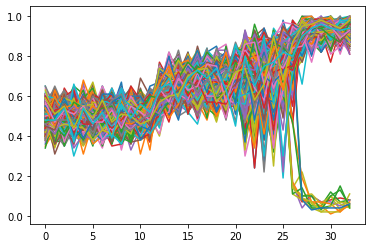

In [55]:
plt.plot(allm5);

Text(0, 0.5, '$\\chi$')

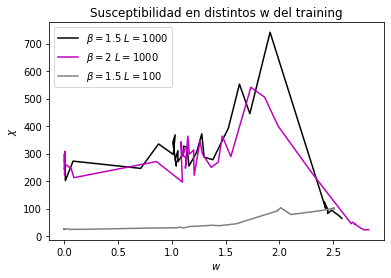

In [79]:
y = np.array(allchi)
plt.plot(alls.squeeze(0), y*1000,'k',label = r'$\beta = 1.5 \ L = 1000$')

y4 = np.array(allchi4)
plt.plot(alls4.squeeze(0), y4*1000,'m',label = r'$\beta = 2 \ L = 1000$')

y5= np.array(allchi5)
plt.plot(alls5.squeeze(0), y5*10,'grey',label = r'$\beta = 1.5 \ L = 100$')


plt.title('Susceptibilidad en distintos w del training')
plt.xlabel('$w$')
plt.legend()
plt.ylabel(r'$\chi$')

Text(0, 0.5, '$\\chi_q$')

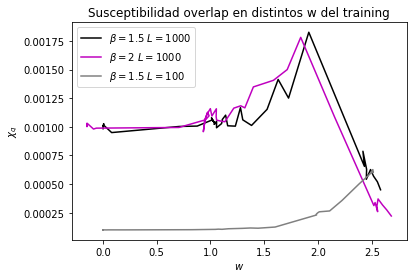

In [82]:
y = np.array(allchichi)
plt.plot(alls.squeeze(0), y*1000,'k',label = r'$\beta = 1.5 \ L = 1000$')

y4 = np.array(allchichi3)
plt.plot(alls3.squeeze(0)-0.15, y4*1000,'m',label = r'$\beta = 2 \ L = 1000$')

y5= np.array(allchichi5)
plt.plot(alls5.squeeze(0), y5*10,'grey',label = r'$\beta = 1.5 \ L = 100$')

plt.title('Susceptibilidad overlap en distintos w del training')
plt.xlabel('$w$')
plt.legend()
plt.ylabel(r'$\chi_q$')

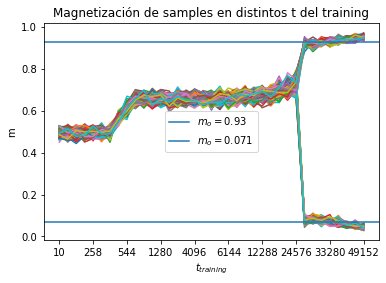

In [25]:

tiempos_uniformes = np.arange(len(allt))

plt.plot(tiempos_uniformes, allm[::-1]);
plt.plot(tiempos_uniformes, allm2[::-1]);
step = len(allt) // 10 + 1 
xticks_positions = tiempos_uniformes[::step]
xticks_labels = allt[::step][::-1]

# Configurar las etiquetas del eje x
plt.xticks(xticks_positions, xticks_labels)

plt.title('Magnetización de samples en distintos t del training')
plt.xlabel('$t_{training}$')
plt.ylabel('m')
plt.axhline(y=0.93,label = r'$m_o = 0.93$')
plt.axhline(y=0.071,label = r'$m_o = 0.071$')
plt.legend(loc='center')
plt.show()

In [13]:

allt2 = []
allm2 = []
allchi2 = []
alls2 = []

filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.ones(1000,100)

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    _,s,_ = torch.svd(W)
    alls2.append(s.reshape(s.shape[0],1))

    
    m,chi,X = Sampling(X,W,b_h,b_v,it)
    
    allt2.append(t)
    allm2.append(m)
    allchi2.append(chi)
    
alls2 = torch.cat(tuple(alls2),dim=1)

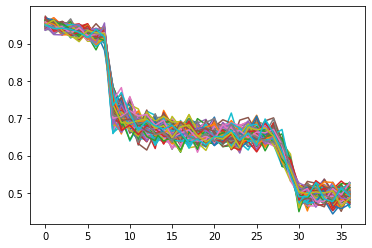

In [15]:
plt.plot(allm2);

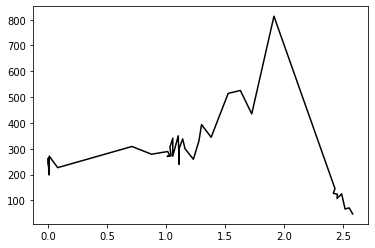

In [12]:
y = np.array(allchi)

plt.plot(alls.squeeze(0), y*1000,'k',label = r'$\beta = 1.5$')

Text(0, 0.5, '$\\chi$')

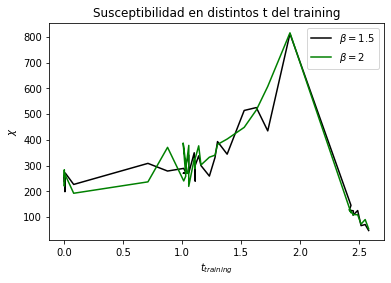

In [26]:
y = np.array(allchi)
y2 = np.array(allchi2)
plt.plot(alls.squeeze(0), y*1000,'k',label = r'$\beta = 1.5$')
plt.plot(alls.squeeze(0), y2*1000,'g',label = r'$\beta = 2$')
plt.title('Susceptibilidad en distintos t del training')
plt.xlabel('$t_{training}$')
plt.legend()
plt.ylabel(r'$\chi$')